In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
import scipy.misc
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.python.framework.ops import EagerTensor
from matplotlib.pyplot import imshow
%matplotlib inline


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
BATCH_SIZE = 32
IMG_SIZE = (64, 64)
directory = "/kaggle/input/garbage-classification/garbage_classification/"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42
                                            )
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42
                                                 )
class_names = train_dataset.class_names
print(class_names)

Found 15515 files belonging to 12 classes.
Using 12412 files for training.
Found 15515 files belonging to 12 classes.
Using 3103 files for validation.
['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


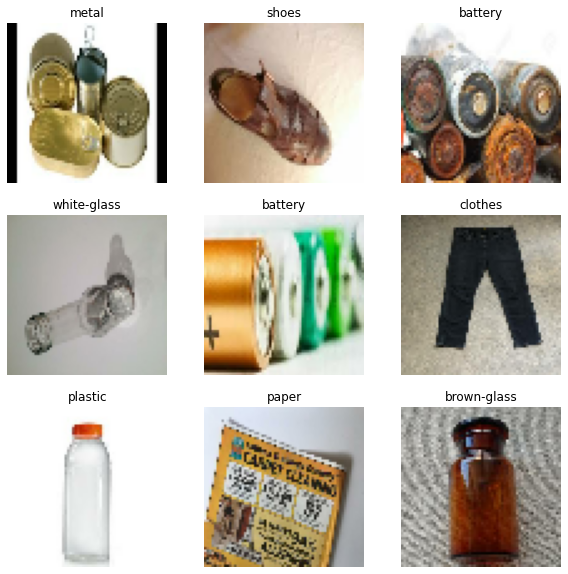

In [3]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [4]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_dataset.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.34111282 1.0


In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [6]:
# def data_augmenter():
#     data_augmentation = tf.keras.Sequential([
#       tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
#       tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
#     ])
#     return data_augmentation

# augmenter = data_augmenter()
# data_augmentation = data_augmenter()
# for image, label in train_dataset.take(1):
#     plt.figure(figsize=(10, 10))
#     first_image = image[0]
#     for i in range(9):
#         ax = plt.subplot(3, 3, i + 1)
#         augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
#         plt.imshow(augmented_image[0] / 255)
#         plt.axis('off')
#         print(label)

In [7]:
def identity_block(X, f, filters, training=True, initializer=random_uniform):
    """
    Implementation of the identity block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    cache = []
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)
    
    ## Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = f, strides = (1,1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)

    ## Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    
    ## Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = tf.keras.layers.Add()([X_shortcut,X])
    X = Activation('relu')(X)
    return X

In [8]:
np.random.seed(1)
X1 = np.ones((1, 4, 4, 3)) * -1
X2 = np.ones((1, 4, 4, 3)) * 1
X3 = np.ones((1, 4, 4, 3)) * 3

X = np.concatenate((X1, X2, X3), axis = 0).astype(np.float32)

A3 = identity_block(X, f=2, filters=[4, 4, 3],
                   initializer=lambda seed=0:constant(value=1),
                   training=False)
A3np = A3.numpy()
print(np.around(A3.numpy()[:,(0,-1),:,:].mean(axis = 3), 5))
resume = A3np[:,(0,-1),:,:].mean(axis = 3)
print(resume[1, 1, 0] , resume[1, 1, 0])

[[[  0.        0.        0.        0.     ]
  [  0.        0.        0.        0.     ]]

 [[192.71236 192.71236 192.71236  96.85619]
  [ 96.85619  96.85619  96.85619  48.9281 ]]

 [[578.1371  578.1371  578.1371  290.56854]
  [290.56854 290.56854 290.56854 146.78427]]]
96.85619 96.85619


In [9]:
def convolutional_block(X, f, filters, s = 2, training=True, initializer=glorot_uniform):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer, 
                   also called Xavier uniform initializer.
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    
    # First component of main path glorot_uniform(seed=0)
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)

    ## Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = f, strides = (1, 1), padding='same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)

    ## Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1, 1), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    
    ##### SHORTCUT PATH ##### (≈2 lines)
    X_shortcut = Conv2D(filters = F3, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut, training=training)

    # Final step: Add shortcut value to main path (Use this order [X, X_shortcut]), and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [10]:
np.random.seed(1)
#X = np.random.randn(3, 4, 4, 6).astype(np.float32)
X1 = np.ones((1, 4, 4, 3)) * -1
X2 = np.ones((1, 4, 4, 3)) * 1
X3 = np.ones((1, 4, 4, 3)) * 3

X = np.concatenate((X1, X2, X3), axis = 0).astype(np.float32)

A = convolutional_block(X,
                        f = 2,
                        filters = [2, 4, 6],
                        training=False)

assert type(A) == EagerTensor, "Use only tensorflow and keras functions"
assert tuple(tf.shape(A).numpy()) == (3, 2, 2, 6), "Wrong shape. "
print(A[0])
print('\033[92mAll tests passed!')

tf.Tensor(
[[[0.         0.66683817 0.         0.         0.888539   0.5274254 ]
  [0.         0.65053666 0.         0.         0.8959285  0.49965227]]

 [[0.         0.6312079  0.         0.         0.86362475 0.47643146]
  [0.         0.56883204 0.         0.         0.8553412  0.417093  ]]], shape=(2, 2, 6), dtype=float32)
All tests passed!


In [11]:
def ResNet50(input_shape = (64, 64, 3), classes = 12):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])

    ### START CODE HERE
    
    ## Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128,128,512], s = 2)
    X = identity_block(X, 3, [128,128,512])
    X = identity_block(X, 3, [128,128,512])
    X = identity_block(X, 3, [128,128,512])
    
    ## Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024]) 
    X = identity_block(X, 3, [256, 256, 1024]) 

    ## Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    ## AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = tf.keras.layers.AveragePooling2D()(X)
    
    ### END CODE HERE

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [12]:
model = ResNet50(input_shape = (64, 64, 3), classes = 12)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 32, 32, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization_7 (BatchNor (None, 32, 32, 64)   256         conv2d_7[0][0]                   
______________________________________________________________________________________________

In [13]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [14]:
model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=3
)

Epoch 1/3
388/388 [==============================] - 942s 2s/step - loss: 2.6377 - accuracy: 0.4135 - val_loss: 1.4460 - val_accuracy: 0.5469
Epoch 2/3
388/388 [==============================] - 922s 2s/step - loss: 1.4540 - accuracy: 0.5593 - val_loss: 1.2109 - val_accuracy: 0.6165
Epoch 3/3
388/388 [==============================] - 977s 3s/step - loss: 1.2696 - accuracy: 0.6067 - val_loss: 1.1086 - val_accuracy: 0.6484


In [ ]:
model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=10
)